### 1. library

In [1]:
library(tidyverse)  # 데이터 처리 및 시각화
library(caret)      # 데이터 전처리, 분할, 평가
library(class)      # KNN 분류 함수
library(ggplot2)
library(gridExtra)

Warning message:
“Your system is mis-configured: ‘/var/db/timezone/localtime’ is not a symlink”
Warning message:
“‘/var/db/timezone/localtime’ is not identical to any known timezone file”
── Attaching core tidyverse packages ───────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### 2. Data

In [2]:
dt <- read.csv("fake_bills.csv", sep = ";")

### 3. 전처리

`-` 결측값 제거

In [3]:
dt <- na.omit(dt)

`-` 목표변수 범주형으로 변환

In [4]:
dt$is_genuine <- as.factor(dt$is_genuine)

`-` X,y분리

In [5]:
X <- dt %>% select(-is_genuine)
y <- dt$is_genuine

`-` 표준화

In [6]:
pre_proc <- preProcess(X, method = c("center", "scale"))
X_scaled <- predict(pre_proc, X)

### 4. 적합

`-` 반복 설정

In [7]:
T <- 100
N <- nrow(X_scaled)
n_train <- round(0.7 * N)

k_range <- 1:100
acc_matrix <- matrix(NA, nrow = T, ncol = length(k_range))

`-` 반복 : train/test 나눠서 k별 정확도 저장

In [8]:
N <- nrow(X_scaled)

In [9]:
for (t in 1:T) {
  set.seed(t)
  train_idx <- sample(1:N, n_train, replace = FALSE)
  test_idx <- setdiff(1:N, train_idx)
  
  x_train <- X_scaled[train_idx, ]
  x_test <- X_scaled[test_idx, ]
  y_train <- y[train_idx]
  y_test <- y[test_idx]
  
  for (k in k_range) {
    pred <- knn(train = x_train, test = x_test, cl = y_train, k = k)
    acc_matrix[t, k] <- mean(pred == y_test)
  }
}

`-` 평균 정확도 계산

In [10]:
avg_acc <- colMeans(acc_matrix, na.rm = TRUE)
results <- data.frame(k = k_range, Accuracy = avg_acc)

`-` 시각화

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


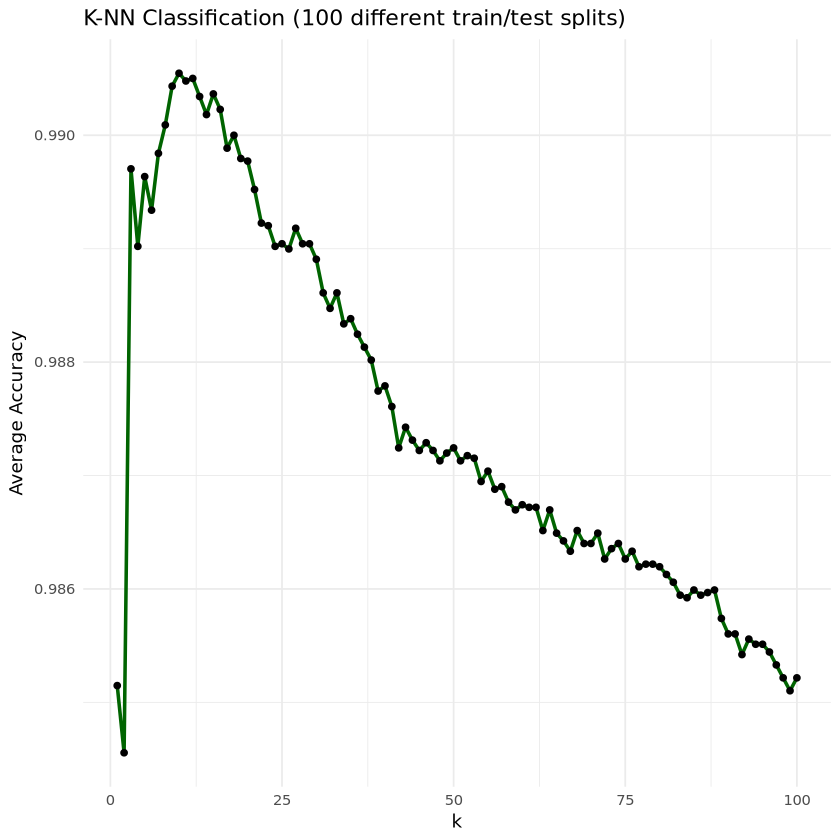

In [11]:
ggplot(results, aes(x = k, y = Accuracy)) +
  geom_line(color = "darkgreen", size = 1) +
  geom_point(color = "black") +
  labs(title = "K-NN Classification (100 different train/test splits)",
       x = "k",
       y = "Average Accuracy") +
  theme_minimal()

`-` 최적의 k

In [12]:
best_k <- results$k[which.max(results$Accuracy)]
cat("★ 최적의 k 값:", best_k, "\n")

★ 최적의 k 값: 10 


`-` 최종 예측 비교

In [13]:
set.seed(999)
train_index <- sample(1:N, n_train, replace = FALSE)
test_index <- setdiff(1:N, train_index)

x_train <- X_scaled[train_index, ]
x_test <- X_scaled[test_index, ]
y_train <- y[train_index]
y_test <- y[test_index]

`-` 최적 k 예측

In [14]:
best_pred <- knn(train = x_train, test = x_test, cl = y_train, k = best_k)

`-` k=100 예측

In [16]:
k100_pred <- knn(train = x_train, test = x_test, cl = y_train, k = 100)

`-` 정확도 비교

In [17]:
acc_best <- mean(best_pred == y_test)
acc_k100 <- mean(k100_pred == y_test)

cat("✔️ Best k (", best_k, ") 정확도:", round(acc_best * 100, 2), "%\n")
cat("✔️ k = 100 정확도:", round(acc_k100 * 100, 2), "%\n")


✔️ Best k ( 10 ) 정확도: 99.32 %
✔️ k = 100 정확도: 98.63 %


`-` 혼동행렬 출력

In [18]:
cat("\n▶ 혼동행렬 (Best k):\n")
print(confusionMatrix(best_pred, y_test))

cat("\n▶ 혼동행렬 (k = 100):\n")
print(confusionMatrix(k100_pred, y_test))


▶ 혼동행렬 (Best k):
Confusion Matrix and Statistics

          Reference
Prediction False True
     False   153    0
     True      3  283
                                          
               Accuracy : 0.9932          
                 95% CI : (0.9802, 0.9986)
    No Information Rate : 0.6446          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.985           
                                          
 Mcnemar's Test P-Value : 0.2482          
                                          
            Sensitivity : 0.9808          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9895          
             Prevalence : 0.3554          
         Detection Rate : 0.3485          
   Detection Prevalence : 0.3485          
      Balanced Accuracy : 0.9904          
                                          
       'Positive' Class : False           
   

`-` 그래프로 출력

In [19]:
# 혼동행렬 생성
cm_best <- confusionMatrix(best_pred, y_test)
cm_k100 <- confusionMatrix(k100_pred, y_test)

# 데이터프레임 변환
cm_best_df <- as.data.frame(cm_best$table)
cm_k100_df <- as.data.frame(cm_k100$table)

# 열의 순서 (True → False)
cm_best_df$Reference  <- factor(cm_best_df$Reference,  levels = c("True", "False"))  
cm_k100_df$Reference  <- factor(cm_k100_df$Reference,  levels = c("True", "False"))  

`-` 그래프 1 : 최적k 혼동행렬

In [20]:
p1 <- ggplot(cm_best_df, aes(x = Reference, y = Prediction)) +
  geom_tile(fill = "white", color = "black", linewidth = 0.8) +  
  geom_text(aes(label = Freq), size = 6, fontface = "bold") +
  labs(title = paste0("Confusion Matrix (k = ", best_k, ")"),
       x = "Actual", y = "Predicted") +
  theme_minimal(base_family = "Helvetica") +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 11, face = "bold"),
    panel.grid = element_blank(),
    legend.position = "none"
  )

`-` 그래프 2 : k=100 혼동행렬

In [21]:
p2 <- ggplot(cm_k100_df, aes(x = Reference, y = Prediction)) +
  geom_tile(fill = "white", color = "black", linewidth = 0.8) +
  geom_text(aes(label = Freq), size = 6, fontface = "bold") +
  labs(title = "Confusion Matrix (k = 100)",
       x = "Actual", y = "Predicted") +
  theme_minimal(base_family = "Helvetica") +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 11, face = "bold"),
    panel.grid = element_blank(),
    legend.position = "none"
  )

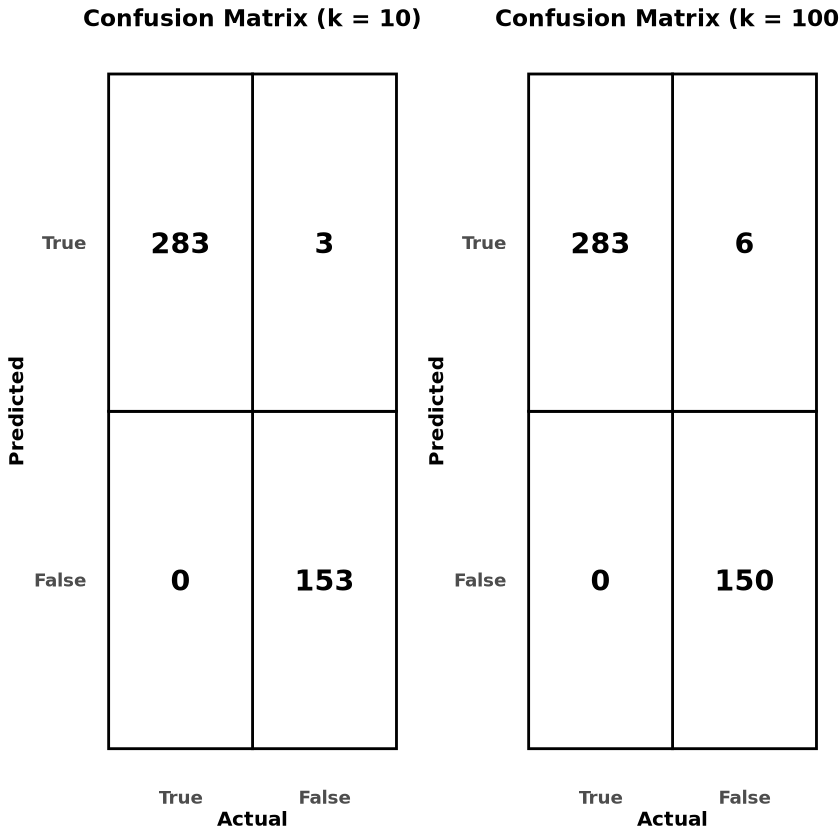

In [22]:
grid.arrange(p1, p2, nrow = 1)